<a href="https://colab.research.google.com/github/DanishFaraaz/Deep-Learning-Projects/blob/main/24_Pytorch_Feature_Extraction_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
import tqdm
import torch.nn as nn
import pandas as pd
from PIL import Image
from torchsummary import summary
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.vgg16(pretrained=True)
model = model.to(device)

summary(model, input_size=(3,224,224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 326MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

**Remove top dense fully connected layers**

In [2]:
new_classifier = nn.Sequential(*list(model.classifier.children())[:-7])
model.classifier = new_classifier

In [3]:
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [4]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:22<00:00, 37.1MB/s]


In [5]:
train_dir = './train'
test_dir = './test1'

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print(f'Number of images in {train_dir} is {len(train_files)}')
print(f'Number of images in {test_dir} is {len(test_files)}')

transformations = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

class Dataset():
  def __init__(self, filelist, filepath, transform=None):
    self.filelist = filelist
    self.filepath = filepath
    self.transform = transform

  def __len__(self):
    return int(len(self.filelist))

  def __getitem__(self, index):
    imgpath = os.path.join(self.filepath, self.filelist[index])
    img = Image.open(imgpath)

    if 'dog' in imgpath:
      label = 1
    else:
      label = 0

    if self.transform is not None:
      img = self.transform(img)

    return (img, label)

train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

train_dataset = torch.utils.data.DataLoader(dataset=train, batch_size=32, shuffle=True)
val_dataset = torch.utils.data.DataLoader(dataset=val, batch_size=32, shuffle=True)

Number of images in ./train is 25000
Number of images in ./test1 is 12500


**Extract our features using VGG16**

In [6]:
image_names = os.listdir('./train')
image_paths = ['./train/' + x for x in image_names]

In [7]:
model.eval()
model = model.cuda()

with torch.no_grad():
  features = None
  image_labels = None

  for data, label in tqdm.tqdm(train_dataset):
    x = data.cuda()
    output = model(x)

    if features is not None:
      features = torch.cat((features, output), 0)
      image_labels = torch.cat((image_labels, label), 0)
    else:
      features = output
      image_labels = label

  features = features.view(features.size(0), -1) # reshape the tensor to 25000 X 25088

100%|██████████| 782/782 [01:21<00:00,  9.60it/s]


In [8]:
features.size(0)

25000

In [9]:
image_labels.shape

torch.Size([25000])

**Train LR classifier using those features**

In [10]:
features_np = features.cpu().numpy()
image_labels_np = image_labels.cpu().numpy()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(features_np, image_labels_np, test_size=0.2, random_state=7)

glm = LogisticRegression(C=0.1)
glm.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

In [12]:
accuracy = glm.score(X_test, y_test)
print(f'Accuracy on the validation set using Logistic Regression is {accuracy*100}%')

Accuracy on the validation set using Logistic Regression is 97.02%


**Running Inference**

In [13]:
image_names_test = os.listdir('./test1')
image_paths_test = ['./test1/' + x for x in image_names_test]

In [15]:
from torch.autograd import Variable

imsize = 224

loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

def image_loader(loader, image_name):
  image = Image.open(image_name)
  image = loader(image).float()
  image = torch.tensor(image, requires_grad=True)
  image = image.unsqueeze(0)
  return image

In [16]:
import random

test_sample = random.sample(image_paths_test, 12)
model.eval()

def test_img():
  result_lst = []
  for path in test_sample:
    image = image_loader(loader, path)
    output = model(image.to(device))
    output = output.cpu().detach().numpy()
    result = glm.predict(output)
    result = 'dog' if float(result) > 0.5 else 'cat'
    result_lst.append(result)
  return result_lst

In [17]:
pred_results = test_img()
pred_results

<ipython-input-15-861057f7f9c1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)
<ipython-input-15-861057f7f9c1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)
<ipython-input-15-861057f7f9c1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)
<ipython-input-15-861057f7f9c1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.c

['dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'cat',
 'cat',
 'cat',
 'dog',
 'dog',
 'dog',
 'cat']

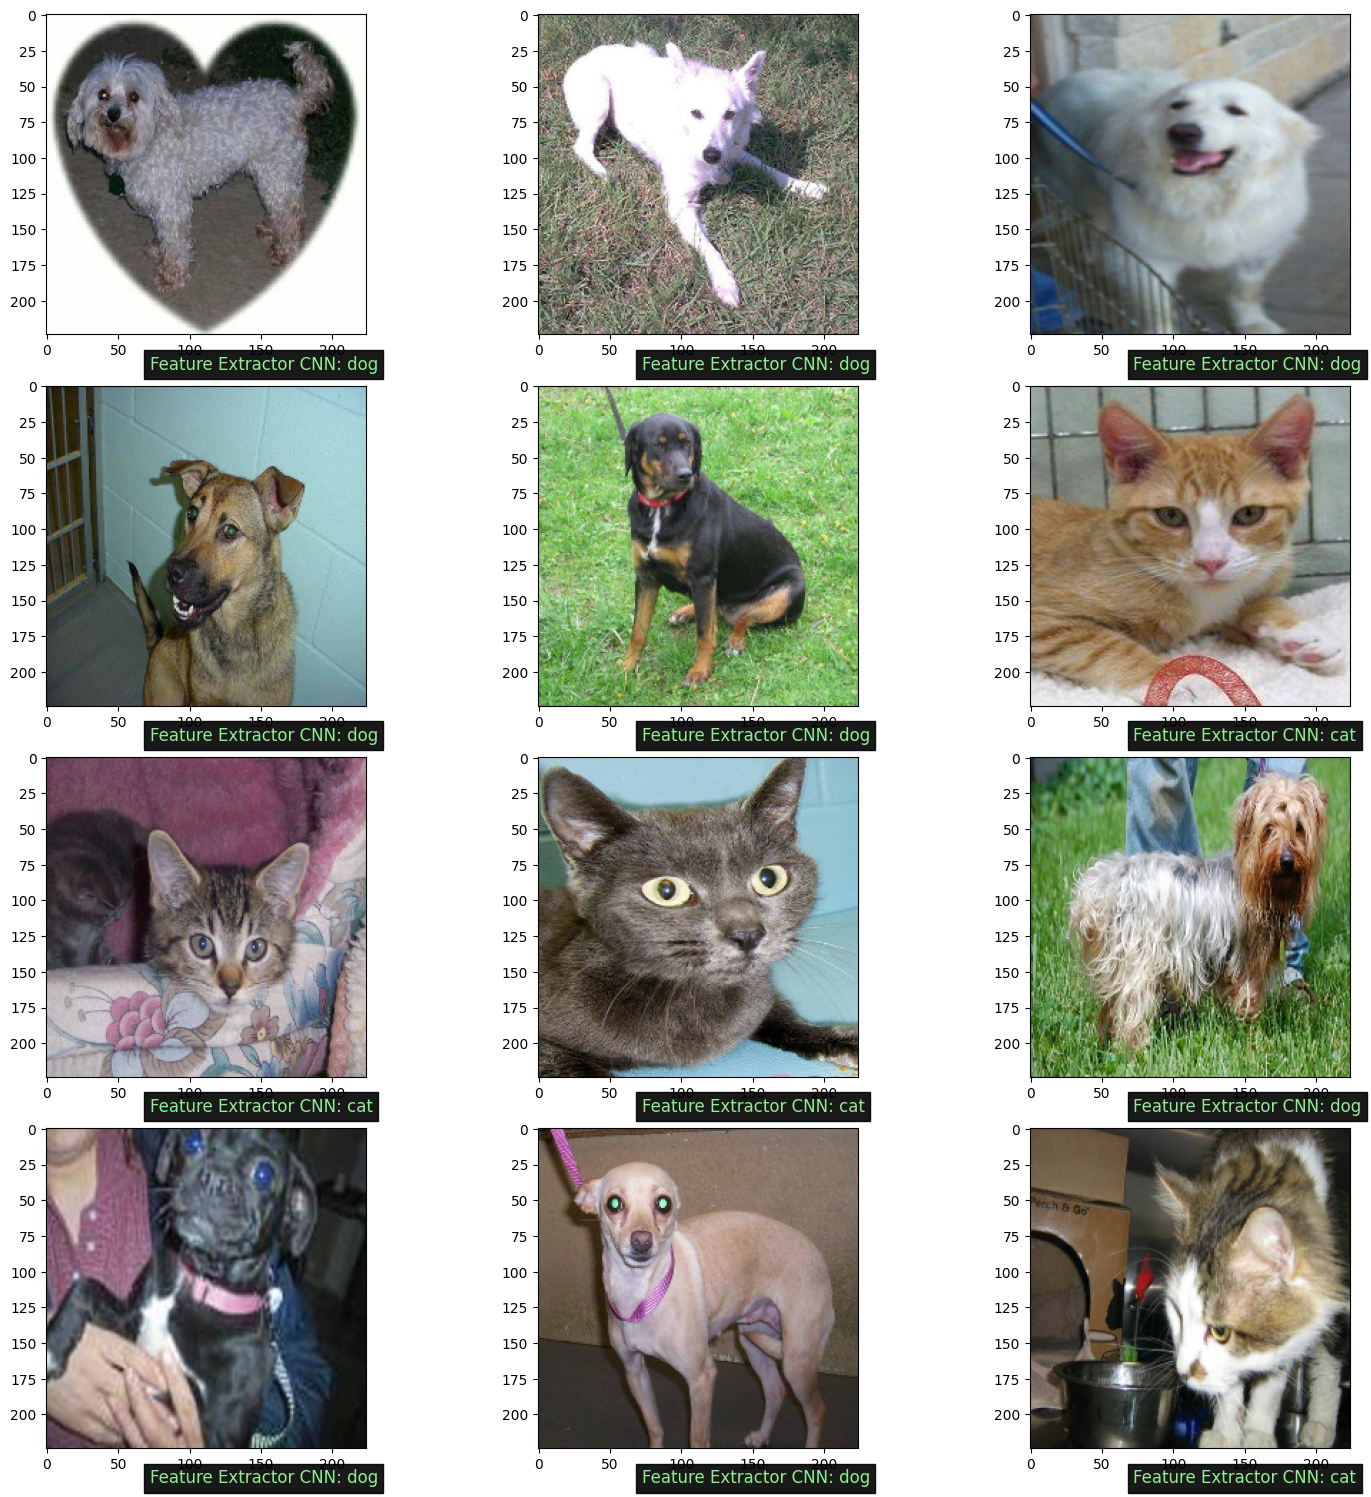

In [19]:
import cv2

plt.figure(figsize=(15,15))

for i in range(0, 12):
  plt.subplot(4, 3, i+1)
  result = pred_results[i]
  img = test_sample[i]
  image = cv2.imread(img)
  image = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.text(72, 248, f'Feature Extractor CNN: {result}', color='lightgreen', fontsize=12, bbox=dict(facecolor='black', alpha=0.9))
  plt.imshow(image)

plt.tight_layout()
plt.show()